# Сентимент для твиттера

[Данные](https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit) [sentiment140](http://help.sentiment140.com/for-students) это англоязычный твиттер.

Он уже поделен на train/test. Train часть была размечена автоматически -- по наличию определенных эмоджи в тексте.

Тест часть была размечена людьми. Таким образом задача состоит в том, чтобы обучиться на шумных данных и сделать хорошие предсказания на тестовой выборке. И, конечно же, нужно превзойти бейзлайн решение.

Запустите следующую ячейку, если работаете в google colab. Это поможет быстро загрузить данные в текущий runtime.

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B04GJPshIjmPRnZManQwWEdTZjg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B04GJPshIjmPRnZManQwWEdTZjg" -O dataset.zip && rm -rf /tmp/cookies.txt

--2018-10-09 19:17:12--  https://docs.google.com/uc?export=download&confirm=&id=0B04GJPshIjmPRnZManQwWEdTZjg
Resolving docs.google.com... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘docs.google.com’


Для google colab: распаковка данных внутри runtime.

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


Загрузка предобученных эмбеддингов.

In [3]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

--2018-10-07 20:50:41--  http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Resolving nlp.stanford.edu... 171.64.67.140
Connecting to nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip [following]
--2018-10-07 20:50:41--  https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Connecting to nlp.stanford.edu|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408741 (1,4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1,42G  1,15MB/s    in 43m 55s 

2018-10-07 21:34:37 (564 KB/s) - ‘glove.twitter.27B.zip’ saved [1520408741/1520408741]



In [4]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [2]:
import pandas as pd
import numpy as np
import re
import gc

np.random.seed(101)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv("./training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1', sep=',')
train.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
train = train.iloc[np.random.permutation(len(train))][:100000]
train.head()

,sentiment,id,time,flag,username,text
250977,0,1983354434,Sun May 31 12:59:58 PDT 2009,NO_QUERY,Yushimi,@Kardboard yea ugh. I don't wanna move either...
150064,0,1883616871,Fri May 22 08:50:14 PDT 2009,NO_QUERY,philwade,"Guess there's a first time for everything, my ..."
710275,0,2257860040,Sat Jun 20 15:00:38 PDT 2009,NO_QUERY,JBnVFCLover786,My cousin is going to America and it's NOT FAI...
367641,0,2049251254,Fri Jun 05 16:33:26 PDT 2009,NO_QUERY,ChelseyHart,@mitchelmusso Ahh this is my first comment to ...
575674,0,2211153017,Wed Jun 17 12:30:03 PDT 2009,NO_QUERY,GGirl33,taking care of my good friend jessica she is s...


In [4]:
train.sentiment.unique()

array([0, 4])

In [5]:
test = pd.read_csv("./testdata.manual.2009.06.14.csv", encoding='latin-1', header=None)
test.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
test = test.drop(test[test.sentiment == 2].index)
test.head()

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [6]:
test.sentiment.unique()

array([4, 0])

Предобработка твиттов очень важна.

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    #tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

def preprocess(text, remove_stopwords=True):
    text = clean_tweet(text)
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        
    msg = " ".join(text)
    
    for t in text:
        if t.startswith('http'):
            msg = msg.replace(t, 'URL')
        if t.startswith('@'):
            msg = msg.replace(t, 'username')
    
    text = msg
    
    # Clean the text
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"    ", " ", text) # Remove any extra spaces
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    # Return a list of words
    return(text)

[nltk_data] Downloading package stopwords to /home/pavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Example of preprocessor work
print('**BEFORE PREPROC:**', train['text'].values[0])
print('-'*4)
print('**AFTER PREPROC:** ', preprocess(train['text'].values[0]))

**BEFORE PREPROC:** @Kardboard yea  ugh. I don't wanna move either because all my textbooks and noted are all out on the table. Sigh.
----
**AFTER PREPROC:**  username yea ugh wanna move either textbooks noted table sigh


In [9]:
train = train[['text','sentiment']]
train['text'] = list(map(preprocess, train['text']))
train[:4]

,text,sentiment
250977,username yea ugh wanna move either textbooks n...,0
150064,guess there s first time everything cars broke...,0
710275,cousin going america fair know wayyy pppl does...,0
367641,username ahh first comment youu love xxxand pl...,0


In [10]:
test['text'] = list(map(preprocess, test['text']))
test[:4]

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,username loooooooovvvvvveee kindle dx cool fan...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,reading kindle love lee childs good read
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,ok first assesment kindle fucking rocks
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,username love kindle i ve mine months never lo...


In [11]:
# Поменяем метки классов на более естественные:

# 0:negative, 4:positive
translate_labels = {0:0, 4:1} # 0:0 -- просто для наглядности:)
train.sentiment = [translate_labels[t] for t in train.sentiment]
test.sentiment = [translate_labels[t] for t in test.sentiment]

In [12]:
train.to_csv("preprocessed_train.csv", index=False)

# Бейзлайн

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer 
transformer = TfidfVectorizer(min_df=40, max_features=6000)
X_train = transformer.fit_transform(train.text)

In [14]:
X_test = transformer.transform(test.text)

In [15]:
y_train = train.sentiment
y_test = test.sentiment

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# check on test part
from sklearn.metrics import f1_score, roc_auc_score 
test_pred = lr.predict_proba(X_test)

In [18]:
test_pred[:5]

array([[0.04662516, 0.95337484],
       [0.05971427, 0.94028573],
       [0.18586407, 0.81413593],
       [0.72101234, 0.27898766],
       [0.51532991, 0.48467009]])

**Для удобства возьмем в качестве метрики roc_auc**

In [19]:
roc_auc_score(y_test, test_pred[:,1])

0.8664400571180232

Это и есть то самое значение, которое необходимо превзойти.

# Tensorflow вступает в игру

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

/home/pavel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16444951542076309917
]


**Готовим датасет**

In [22]:
tokenizer = Tokenizer(char_level=False)

In [23]:
tokenizer.fit_on_texts(train.text)
vocab_size = len(tokenizer.word_index)

In [24]:
vocab_size

61896

In [25]:
train_seqs = tokenizer.texts_to_sequences(train.text)

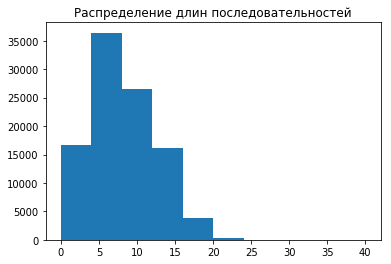

In [26]:
plt.hist([len(x) for x in train_seqs])
plt.title("Распределение длин последовательностей")
plt.show()

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
# обрезаем последовательности в начале, добиваем нулями до 20 при необходимости в конце
# тут можно все поменять на свой вкус, конечно же
padded = pad_sequences(train_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [29]:
padded.shape

(100000, 20)

#### Загружаем эмбеддинги

In [1]:
#Load GLOVE vectors
filepath_glove = 'glove.twitter.27B.100d.txt'
glove_vocab = []
glove_embd=[]
embedding_dict = {}
 
file = open(filepath_glove,'r',encoding='UTF-8')
for line in file.readlines():
    row = line.strip().split(' ')
    vocab_word = row[0]
    glove_vocab.append(vocab_word)
    embed_vector = [float(i) for i in row[1:]] # convert to list of float
    embedding_dict[vocab_word]=embed_vector
file.close()

In [30]:
len(embedding_dict)

1193515

In [31]:
len(tokenizer.word_index)

61896

Подготовим матрицу для инициализации матрицы эмбеддингов модели.

In [32]:
# prepare embedding matrix
num_words = vocab_size+1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [33]:
embedding_matrix.shape

(61897, 100)

In [34]:
embedding_matrix[3]

array([ 8.5651e-02, -1.4665e-02, -2.0531e-01, -1.3928e-01, -4.5531e-01,
        6.6880e-01, -1.5448e-01,  3.2308e-01, -5.1561e-01,  9.6171e-02,
       -3.6832e-02,  2.7032e-01, -2.8622e+00,  4.1572e-01, -2.2041e-01,
       -8.2353e-01, -7.0891e-01, -3.1757e-01, -7.4595e-01,  1.1605e+00,
       -2.9937e-04, -1.3276e-02,  5.3844e-01,  3.2003e-01,  3.9048e-01,
       -2.2494e+00, -6.9214e-01, -3.2294e-01,  6.8427e-01,  5.9943e-01,
       -9.1371e-02, -5.6070e-01, -3.1685e-01, -1.1708e-01,  1.7076e+00,
       -6.3555e-01, -4.3287e-01, -2.2535e-01,  3.5899e-01,  2.3817e-01,
       -1.8517e+00,  3.0939e-01,  4.7932e-01, -8.7741e-01, -1.8584e-01,
       -5.0600e-01,  2.8379e-02, -7.2791e-01,  8.4749e-02, -7.0856e-01,
        3.5898e-01, -2.6869e-01,  1.2857e-01,  3.7286e-01,  3.6686e-01,
       -2.9323e-01,  3.7081e-01, -6.0298e-01,  2.4040e-01, -5.0550e-01,
       -2.8867e-01, -4.5598e-01,  7.7508e-02,  1.0154e-01,  2.9443e-01,
        4.2504e-01, -2.3515e-01,  4.4486e-01, -1.5291e-01, -1.04

**Теперь Tensorflow точно вступает в игру**

Изготовим теперь удобный **tf.data.Dataset**

Более подробно можно прочитать об этом [здесь](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428) и [здесь](https://www.tensorflow.org/performance/datasets_performance)

In [75]:
import gc
gc.collect()

6874

In [76]:
tf.reset_default_graph()

In [77]:
emb_size = 100
batch_size = tf.placeholder(tf.int64, shape=())  #made batch_size a placeholder
learning_rate = 0.001
EPOCHS = 1

In [78]:
y_train = np.array(train.sentiment)
y_train = np.expand_dims(y_train, axis=1)

In [79]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [80]:
# MY CODE
np.count_nonzero(y_train == [0])

49989

In [81]:
# MY CODE
np.count_nonzero(y_train == [1])

50011

In [82]:
dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(batch_size).repeat().batch(batch_size)

С помощью dataset API можно удобно делать итератор для имеющихся данных.

In [83]:
my_iterator = dataset.make_initializable_iterator() #Changed name iterator to my_iterator
get_next = my_iterator.get_next()
print(get_next)
inputs, labels = get_next

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(?, 1) dtype=int64>)


**Модель**

Мы хотим сделать очень простую модель с однослойной LSTM ячейкой, которая будет пробегать по всей последовательности из слов длины 20. На каждом элементе последовательности LSTM выдает output. Мы хотим использовать output'ы для предсказания вероятности принадлежности последовательности к классу позитивных твиттов.

Матрицу эмбеддингов фиксируем, она не будет тренироваться в процессе обучения модели. 

In [84]:
embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)

Эта функция позволяет по индексам элементов входной последовательности (`inputs`) составить матрицу из соответствующих векторов слов из матрицы эмбеддингов (`embedding_mtx`).

In [85]:
inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)

Посмотрим на размерность полученной матрицы: [размер батча, длина последовательности, размерность эмбеддинга]

In [86]:
inputs_embedded

<tf.Tensor 'embedding_lookup:0' shape=(?, 20, 100) dtype=float32>

The number of units is a parameter in the LSTM, referring to the dimensionality of the hidden state and dimensionality of the output state (they must be equal)

In [87]:
outputs, states = tf.nn.dynamic_rnn(cell=tf.nn.rnn_cell.LSTMCell(20), inputs=inputs_embedded, dtype=tf.float32)

outputs -- это выходы LSTM после каждого элемента последовательности.



In [88]:
outputs = tf.layers.flatten(outputs)

In [89]:
logits = tf.layers.dense(inputs=outputs, units=1)

In [90]:
logits

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [91]:
probs = tf.nn.sigmoid(logits)
probs

<tf.Tensor 'Sigmoid:0' shape=(?, 1) dtype=float32>

In [92]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)

In [93]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [94]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [95]:
losses = []
num_epochs = 1
num_iter_per_epoch = 3000

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(my_iterator.initializer, feed_dict={batch_size:10})

for i in range(num_epochs):
  print('Epoch ',i)
  aver_loss = 0.
  for j in range(num_iter_per_epoch):
    #sess.run(my_iterator.initializer, feed_dict={batch_size:100})
    loss_cur, _ = sess.run([loss, train_op])
    aver_loss += loss_cur
    if j % 300 == 0:
      print('Loss: ', aver_loss / 300.)
      aver_loss = 0.
      
    losses.append(loss_cur)

Epoch  0
Loss:  0.002528295914332072
Loss:  0.6123968171079953
Loss:  0.5503690761327743
Loss:  0.5417592176795005
Loss:  0.5247061252593994
Loss:  0.5142904767394065
Loss:  0.5204855366051198
Loss:  0.5005177731315295
Loss:  0.5143412526448568
Loss:  0.5211452835301558


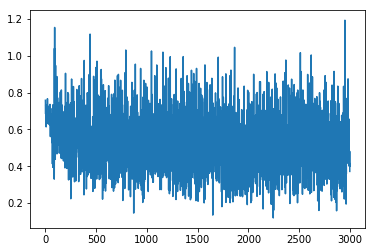

In [96]:
plt.plot(losses)

**Измеряем точность**

In [97]:
test_seqs = tokenizer.texts_to_sequences(test.text)
padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [98]:
test_pred = sess.run(probs, feed_dict={inputs: padded_test})

In [99]:
roc_auc_score(y_test, test_pred)

0.8931830880983423

** Мы улучшили результат TF-IDF модели, но кажется, что можно куда лучше**

# Задание

Исследуйте нейронку и опишите свои наблюдения. Зафиксируйте количество итераций обучения и меняйте параметры сети. 
Можно выбрать для исследования **любые 3 ** из предложенных вопросов.

1.   Как размер батча влияет на roc_auc?
2.   Как размерность скрытого слоя LSTM влияет на roc_auc?
3.   Что изменится, если вместо всех outputs LSTM взять только последние выходы LSTM на последнем шаге. Улучшился или ухудшился при этом roc_auc?
4.   Что изменится, если взять char эмбеддинги заместо word? Провести эксперименты, добится roc_auc > 0.5. (Это может оказаться сложным, потому можно взять одну эту задачку вместо 3х)
5.   Что изменится, если взять несколько слоев LSTM?
6.   Что изменится, если взять bidirectional LSTM?
7.   Что если обучать эмбеддинги вместе с обучением модели и не использовать инициализацию предобученными эмбеддингами? Сколько потребуется итераций обучения, чтобы достичь результата с использованием предобученных эмбеддингов?

Опишите подробно что вы делали словами и что у вас вышло.
Код тоже нужно оставить доступным для обозрения.

Получилось ли у вас улучшить результат нейронки?

# Ваш отчет здесь


In [131]:
import gc

In [62]:
gc.collect()

174

Сделаем batch_size placeholder-ом

In [63]:
for k in range(10, 100, 10):
    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    #sess.run(tf.initialize_all_variables())
    #print(batch_size)
    sess.run(my_iterator.initializer, feed_dict={batch_size:k})

    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in range(num_iter_per_epoch):
        #sess.run(my_iterator.initializer, feed_dict={batch_size:100})
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 300 == 0:
          print('Loss: ', aver_loss / 300.)
          aver_loss = 0.
      
        losses.append(loss_cur)
    
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print(k, '-', roc_auc_score(y_test, test_pred))
    print('_________________')
    sess.close()

Epoch  0
Loss:  0.002379842201868693
Loss:  0.6299897193908691
Loss:  0.5574150943756103
Loss:  0.5408231464028358
Loss:  0.5282930456101894
Loss:  0.5125926007827123
Loss:  0.5242535371581714
Loss:  0.5018670225640138
Loss:  0.513911392390728
Loss:  0.5259201343854268
10 - 0.8826597131681877
_________________
Epoch  0
Loss:  0.0022969716787338257
Loss:  0.6060105899969737
Loss:  0.5489293801784515
Loss:  0.5303777330120405
Loss:  0.5175716438889504
Loss:  0.5183748721083006
Loss:  0.5039493509133657
Loss:  0.516900606850783
Loss:  0.50747846459349
Loss:  0.5026723119616509
20 - 0.8926864096355622
_________________
Epoch  0
Loss:  0.0023463173707326253
Loss:  0.6004307890931765
Loss:  0.5286483051379521
Loss:  0.5196998031934102
Loss:  0.5024281308054924
Loss:  0.518417315085729
Loss:  0.5034371264775594
Loss:  0.513405885497729
Loss:  0.4948051498333613
Loss:  0.5066860167185465
30 - 0.8883715154901596
_________________
Epoch  0
Loss:  0.002276673913002014
Loss:  0.608101854622364
Los

In [348]:
for k in range(100, 1001, 100):
    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    #sess.run(tf.initialize_all_variables())
    #print(batch_size)
    sess.run(my_iterator.initializer, feed_dict={batch_size:k})

    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in range(num_iter_per_epoch):
        #sess.run(my_iterator.initializer, feed_dict={batch_size:100})
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 300 == 0:
          print('Loss: ', aver_loss / 300.)
          aver_loss = 0.
      
        losses.append(loss_cur)
    
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print(k, '-', roc_auc_score(y_test, test_pred))
    print('_________________')
    sess.close()

Epoch  0
Loss:  0.0023381205399831137
Loss:  0.5437054060896238
Loss:  0.5148271882534027
Loss:  0.500658100148042
Loss:  0.4932437040408452
Loss:  0.4828136827548345
Loss:  0.48222499946753183
Loss:  0.47759351422389346
Loss:  0.4666085907816887
Loss:  0.4679609816273054
100 - 0.8859191655801826
_________________
Epoch  0
Loss:  0.002298218806584676
Loss:  0.5370235718290011
Loss:  0.5026947150627772
Loss:  0.48709537973006567
Loss:  0.47706991036732993
Loss:  0.47316710869471235
Loss:  0.46318626751502356
Loss:  0.45630533357461295
Loss:  0.44934473037719724
Loss:  0.44213198632001877
200 - 0.8835289004780531
_________________
Epoch  0
Loss:  0.0023327364524205526
Loss:  0.533442160487175
Loss:  0.49513400355974835
Loss:  0.4807643680771192
Loss:  0.46990618884563445
Loss:  0.460135114689668
Loss:  0.4520846325159073
Loss:  0.443179200788339
Loss:  0.4331723301609357
Loss:  0.42397677888472873
300 - 0.868535419382877
_________________
Epoch  0
Loss:  0.002300527493158976
Loss:  0.526

Как мы видим, оптимальный результат получается при значении batch_size 70-90, далее результаты нейронки начинают ухудшатся

### Task 2

In [107]:
hidden = [10*i for i in range(1,10)] + [100*i for i in range(1, 11)]
print(hidden)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


In [108]:
for hidden_size in hidden:
    tf.reset_default_graph()
    batch_size = tf.placeholder(tf.int64, shape=()) 
    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(batch_size).repeat().batch(batch_size)
    my_iterator = dataset.make_initializable_iterator() #Changed name iterator to my_iterator
    get_next = my_iterator.get_next()
    inputs, labels = get_next
    embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)
    
    
    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    
    lstm_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)    
    outputs, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=inputs_embedded, dtype=tf.float32)
    outputs = tf.layers.flatten(outputs)
    logits = tf.layers.dense(inputs=outputs, units=1)
    probs = tf.nn.sigmoid(logits)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss')
    loss = tf.reduce_mean(loss)

    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(my_iterator.initializer, feed_dict={batch_size:10})
    
    
    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in range(num_iter_per_epoch):
        #sess.run(my_iterator.initializer, feed_dict={batch_size:100})
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 300 == 0:
          print('Loss: ', aver_loss / 300.)
          aver_loss = 0.
      
        losses.append(loss_cur)
    
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print(hidden_size, '-', roc_auc_score(y_test, test_pred))
    print('_______________')
    gc.collect()
    sess.close()

Epoch  0
Loss:  0.0022925553719202675
Loss:  0.6274890024463335
Loss:  0.557229950328668
Loss:  0.5501462929447491
Loss:  0.5291825472315153
Loss:  0.5181784090399743
Loss:  0.5235713150600593
Loss:  0.5048134921491146
Loss:  0.519852185746034
Loss:  0.5276661651333173
10 - 0.8799279816228969
_______________
Epoch  0
Loss:  0.0023632081349690757
Loss:  0.618679030785958
Loss:  0.5472161042193572
Loss:  0.5404152484734853
Loss:  0.5297248768309752
Loss:  0.5112544097503027
Loss:  0.521993125975132
Loss:  0.49946389416853587
Loss:  0.5174602750440439
Loss:  0.5229433760543665
20 - 0.8871919041410568
_______________
Epoch  0
Loss:  0.0025938745339711506
Loss:  0.603918529599905
Loss:  0.544056781232357
Loss:  0.5391336629291376
Loss:  0.5275281204283238
Loss:  0.5132931179801623
Loss:  0.5225823112825553
Loss:  0.5015843677520752
Loss:  0.5161158482730389
Loss:  0.5256319081783295
30 - 0.8917240951139256
_______________
Epoch  0
Loss:  0.002439977725346883
Loss:  0.603698807110389
Loss:  

Как мы видим, размерность скрытого слоя практически не влият на roc_auc